# SimBoost in Python


Drug discovery is a time-consuming, laborious, costly and high-risk process. According to a report by the Eastern Research Group (ERG), it usually takes 10-15 years to develop a new drug. However, the success rate of developing a new molecular entity is only 2.01%. Finding a compound that selectively binds to a particular protein is a highly challenging and typically expensive procedure in the drug development process. \
[SimBoost](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/#CR42) is a machine-learning approch for predicting drug–target binding affinities using gradient boosting.




## 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/DL4H_Spring2022/project1_simboost

/content/drive/MyDrive/DL4H_Spring2022/project1_simboost


### 1.1 Imports libs

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from collections import OrderedDict

### 1.2 Loading data

In [4]:
dataset = 'davis' # 'kiba'

In [5]:
sim_targets = None
sim_drugs = None
bindings = None

if dataset == 'davis':
    target_gene_names = pd.read_csv(dataset+"/target_gene_names.txt", header=None, index_col = 0).index.tolist()
    drug_pubchemIDs = pd.read_csv(dataset+"/drug_PubChem_CIDs.txt", header=None, index_col = 0).index.tolist()
    print(len(drug_pubchemIDs))
    print(len(target_gene_names))
    sim_targets = pd.read_csv(dataset+"/target-target_similarities_WS_normalized.txt", names = target_gene_names, sep = ' ')
    sim_drugs = pd.read_csv(dataset+"/drug-drug_similarities_2D.txt", names = drug_pubchemIDs, sep = ' ')
    bindings = pd.read_csv(dataset+"/drug-target_interaction_affinities_Kd__Davis_et_al.2011.txt", names = target_gene_names, sep = ' ')

elif dataset == 'kiba':
    target_gene_names = list(json.load(open(dataset+"/proteins.txt"), object_pairs_hook=OrderedDict).keys())
    drug_pubchemIDs = list(json.load(open(dataset+"/ligands_can.txt"), object_pairs_hook=OrderedDict).keys())
    sim_targets = pd.read_csv(dataset+"/kiba_target_sim.txt", names = target_gene_names, sep = ' ')
    sim_drugs = pd.read_csv(dataset+"/kiba_drug_sim.txt", names = drug_pubchemIDs, sep = ' ')
    bindings = pd.read_csv(dataset+"/kiba_binding_affinity_v2.txt", names = target_gene_names, sep = ' ')


bindings.index = drug_pubchemIDs
sim_drugs.index = drug_pubchemIDs
sim_targets.index = target_gene_names
target_gene_names = pd.DataFrame(index=target_gene_names)
drug_pubchemIDs = pd.DataFrame(index=drug_pubchemIDs)
sim_targets.shape, sim_drugs.shape, bindings.shape

68
442


((442, 442), (68, 68), (68, 442))

### 1.3 Preprocessing

In davis dataset, standard value is Kd in nM. we used the transformation below:

### $pK_{d}=-log_{10}\frac{K_d}{1e9}$ 


In [6]:
if dataset == 'davis':
    drug_pubchemIDs.sort_index(inplace=True)
    target_gene_names.sort_index(inplace=True)

    sim_targets.sort_index(inplace=True)
    sim_targets = sim_targets / 100

    sim_drugs.sort_index(inplace=True)

    bindings.sort_index(inplace=True)
    transformed_bindings = 9 - np.log10(bindings)

elif dataset == 'kiba':
    drug_pubchemIDs.sort_index(inplace=True)
    target_gene_names.sort_index(inplace=True)
    sim_targets.sort_index(inplace=True)
    sim_drugs.sort_index(inplace=True)
    bindings.sort_index(inplace=True)
    transformed_bindings = bindings

transformed_bindings.head()

,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,...,WEE1,WEE2,YANK1,YANK2,YANK3,YES,YSK1,YSK4,ZAK,ZAP70
5291,5.000000,6.769551,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,7.356547,8.744727,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.585027,5.000000
44259,8.920819,7.657577,6.259637,6.886057,6.769551,7.337242,7.744727,7.443697,7.283997,7.677781,...,5.795880,5.000000,7.886057,7.008774,6.508638,7.283997,6.958607,9.065502,5.000000,7.356547
123631,5.000000,6.397940,5.000000,5.327902,5.568636,6.107905,6.167491,6.337242,6.283997,5.958607,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.619789,5.000000,5.000000
126565,8.508638,6.075721,5.000000,5.309804,5.119186,5.657577,6.000000,6.060481,6.107905,5.602060,...,5.920819,5.102373,5.677781,5.229148,5.096910,6.795880,7.013228,9.283997,5.173925,7.795880
151194,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.721246,5.356547,5.000000


### 1.4 Drug-Target-Binding

In [7]:
drug_target_binding = transformed_bindings.copy()
drug_target_binding.index.name = 'Drug'
drug_target_binding.reset_index(level=0, inplace=True)
drug_target_binding = drug_target_binding.melt(id_vars='Drug', value_vars=transformed_bindings.columns, var_name='Target', value_name='Binding_Val')


print(drug_target_binding.shape)
drug_target_binding.head()

(30056, 3)


,Drug,Target,Binding_Val
0,5291,AAK1,5.000000
1,44259,AAK1,8.920819
2,123631,AAK1,5.000000
3,126565,AAK1,8.508638
4,151194,AAK1,5.000000


### 1.5 Train, Validation and Test Datasets

In [8]:
idx = np.random.permutation(drug_target_binding.index)
train_data = drug_target_binding.iloc[idx[:int(drug_target_binding.shape[0] * 0.66)], :]
val_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.66):int(drug_target_binding.shape[0] * 0.83)], :]
test_data = drug_target_binding.iloc[idx[int(drug_target_binding.shape[0] * 0.83):], :]

train_data.shape, val_data.shape, test_data.shape

((19836, 3), (5110, 3), (5110, 3))

## 2.Feature Engineering

### 2.1 Average Similarities and Binding values

In [9]:
target_gene_names['avg_sim_target'] = sim_targets.mean()
target_gene_names['avg_binding_target'] = train_data.groupby('Target')['Binding_Val'].mean()

target_gene_names.head()

,avg_sim_target,avg_binding_target
AAK1,0.479173,5.653039
ABL1(E255K)-phosphorylated,0.535796,6.305202
ABL1(F317I)-nonphosphorylated,0.535796,5.598950
ABL1(F317I)-phosphorylated,0.535796,5.735100
ABL1(F317L)-nonphosphorylated,0.535796,6.014563


In [10]:
drug_pubchemIDs['avg_sim_drug'] = sim_drugs.mean()
drug_pubchemIDs['avg_binding_drug'] = train_data.groupby('Drug')['Binding_Val'].mean()

drug_pubchemIDs.head()

,avg_sim_drug,avg_binding_drug
5291,0.615412,5.223846
44259,0.559441,7.198511
123631,0.608265,5.263158
126565,0.530206,6.771180
151194,0.558706,5.068247


### 2.2 Drug/Target Similarity Networks

#### 2.2.1 Build Networks

In [11]:
!pip install python-igraph
import igraph

     |████████████████████████████████| 3.1 MB 5.0 MB/s 


In [12]:
import scipy

drug_sim_threshold = 0.5
target_sim_threshold = 0.7
p_value_threshold = 0.05

drug_adj_matrix = sim_drugs.values
drug_z_scores = scipy.stats.zscore(drug_adj_matrix)
drug_p_values = scipy.stats.norm.sf(abs(drug_z_scores))
drug_adj_matrix = (drug_p_values < p_value_threshold)
np.fill_diagonal(drug_adj_matrix, False)
drug_graph = igraph.Graph.Adjacency(drug_adj_matrix.tolist(), mode=1)
drug_graph.vs['label'] = sim_drugs.index.to_list()


target_adj_matrix = sim_targets.values
target_z_scores = scipy.stats.zscore(target_adj_matrix)
target_p_values = scipy.stats.norm.sf(abs(target_z_scores))
target_adj_matrix = (target_p_values < p_value_threshold)
np.fill_diagonal(target_adj_matrix, False)
target_graph = igraph.Graph.Adjacency(target_adj_matrix.tolist(), mode=1)
target_graph.vs['label'] = sim_drugs.index.to_list()


#### 2.2.2 Number of neighbors, PageRank

In [13]:
drug_pubchemIDs['page_rank_drug'] = drug_graph.pagerank()
drug_neighbors = [0] * drug_pubchemIDs.shape[0]
for i in range(drug_pubchemIDs.shape[0]):
  drug_neighbors[i] = len(drug_graph.neighbors(i))
drug_pubchemIDs['n_neighbors_drug'] = drug_neighbors

target_gene_names['page_rank_target'] = target_graph.pagerank()
target_neighbors = [0] * target_gene_names.shape[0]
for i in range(target_gene_names.shape[0]):
  target_neighbors[i] = len(target_graph.neighbors(i))
target_gene_names['n_neighbors_target'] = target_neighbors

### 2.3 Non-negative Matrix Factorization

In [14]:
from sklearn.decomposition import NMF

In [15]:
latent_dim = 9
train_binding_matrix = train_data.pivot(index='Drug', columns='Target', values='Binding_Val')
train_binding_matrix.fillna(5.0, inplace=True)

train_binding_matrix.head()

Target,AAK1,ABL1(E255K)-phosphorylated,ABL1(F317I)-nonphosphorylated,ABL1(F317I)-phosphorylated,ABL1(F317L)-nonphosphorylated,ABL1(F317L)-phosphorylated,ABL1(H396P)-nonphosphorylated,ABL1(H396P)-phosphorylated,ABL1(M351T)-phosphorylated,ABL1(Q252H)-nonphosphorylated,...,YANK3,YES,YSK1,YSK4,ZAK,ZAP70,p38-alpha,p38-beta,p38-delta,p38-gamma
Drug,,,,,,,,,,,,,,,,,,,,,
5291,5.000000,6.769551,8.080922,6.236572,8.602060,6.958607,8.229148,7.187087,5.000000,8.744727,...,5.00000,5.00000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000
44259,8.920819,7.657577,6.259637,6.886057,6.769551,7.337242,5.000000,7.443697,7.283997,5.000000,...,5.00000,5.00000,5.000000,9.065502,5.000000,7.356547,5.0,5.0,5.000000,7.376751
123631,5.000000,6.397940,5.000000,5.000000,5.568636,5.000000,6.167491,5.000000,5.000000,5.958607,...,5.00000,5.00000,5.000000,6.619789,5.000000,5.000000,5.0,5.0,5.000000,5.000000
126565,8.508638,6.075721,5.000000,5.309804,5.119186,5.657577,6.000000,6.060481,6.107905,5.602060,...,5.09691,6.79588,7.013228,9.283997,5.000000,7.795880,5.0,5.0,5.455932,5.000000
151194,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.00000,5.00000,5.000000,5.000000,5.356547,5.000000,5.0,5.0,5.000000,5.000000


In [16]:
model = NMF(n_components=latent_dim, init='random', random_state=0)
P = model.fit_transform(train_binding_matrix)
Q = model.components_

Q_columns = [('target' + str(i)) for i in range(latent_dim)]
P_columns = [('drug' + str(i)) for i in range(latent_dim)]

target_gene_names = pd.concat([target_gene_names, pd.DataFrame(Q.T, index=target_gene_names.index, columns=Q_columns)], axis=1)
drug_pubchemIDs = pd.concat([drug_pubchemIDs, pd.DataFrame(P, index=drug_pubchemIDs.index, columns=P_columns)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


### 2.4 Building Train, Validation and Test Dataset using extracted features

In [17]:
X_train = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=train_data.index)
Y_train = train_data['Binding_Val']
for i in X_train.index:
  X_train.loc[i] = drug_pubchemIDs.loc[train_data.loc[i]['Drug']].append(target_gene_names.loc[train_data.loc[i]['Target']])

X_val = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=val_data.index)
Y_val = val_data['Binding_Val']
for i in X_val.index:
  X_val.loc[i] = drug_pubchemIDs.loc[val_data.loc[i]['Drug']].append(target_gene_names.loc[val_data.loc[i]['Target']])

X_test = pd.DataFrame(columns= target_gene_names.columns.to_list() + drug_pubchemIDs.columns.to_list(), index=test_data.index)
Y_test = test_data['Binding_Val']
for i in X_test.index:
  X_test.loc[i] = drug_pubchemIDs.loc[test_data.loc[i]['Drug']].append(target_gene_names.loc[test_data.loc[i]['Target']])

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((19836, 26), (19836,), (5110, 26), (5110,), (5110, 26), (5110,))

## 3.XGboost

In [18]:
!pip install xgboost
import xgboost
from sklearn.metrics import mean_squared_error

### 3.1 Tune Hyperparameters

In [19]:
def plot_model_results(results):
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    ax.legend()
    plt.ylabel('RMSE')
    plt.show()

In [20]:
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

Validation RMSE: 0.556
Best params =  {'alpha': 0.1, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1}


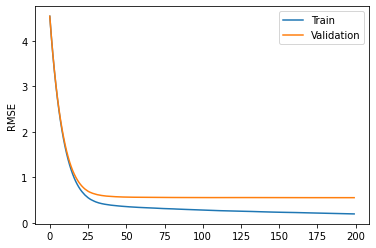

In [21]:
from sklearn.model_selection import GridSearchCV
import pickle

n_estimators = [200]
max_depth = [8, 10, 12]
colsample_bytree = [0.8, 1]
subsample = [0.8, 1]
learning_rate = [0.1]
l1_alpha = [0.1]

params = {'n_estimators': n_estimators, 
          'max_depth': max_depth,
          'colsample_bytree': colsample_bytree,
          'subsample': subsample,
          'learning_rate': learning_rate,
          'alpha': l1_alpha}

learning_rate = 0.1
n_estimators = 200
max_depth = 8
colsample_bytree = 1
subsample = 1

best_model = xgboost.XGBRegressor(objective ='reg:squarederror', eval_metric='rmse')

best_model = GridSearchCV(estimator = best_model, param_grid = params, cv = 5)
best_model.fit(X_train, Y_train,
          eval_set=[(X_train, Y_train), (X_val, Y_val)], 
          verbose=False)

model = xgboost.XGBRegressor(objective ='reg:squarederror', 
                             learning_rate = best_model.best_params_['learning_rate'], 
                             colsample_bytree = best_model.best_params_['colsample_bytree'],
                             max_depth = best_model.best_params_['max_depth'], 
                             subsample = best_model.best_params_['subsample'], 
                             n_estimators = best_model.best_params_['n_estimators'],
                             eval_metric='rmse')

model.fit(X_train, Y_train, 
          eval_set=[(X_train, Y_train), (X_val, Y_val)], 
          verbose=False)

validation_rmse = np.sqrt(mean_squared_error(Y_val, model.predict(X_val)))

print("Validation RMSE: %.3f" % validation_rmse)
print("Best params = ", best_model.best_params_)
plot_model_results(model.evals_result())
pickle.dump(model, open('davis_simboost.pkl', 'wb'))

### 3.2 Evaluation

In [22]:
import tensorflow as tf

def cindex_score(y_true, y_pred):

    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)

    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.compat.v1.matrix_band_part(tf.cast(f, tf.float32), -1, 0)

    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f) #select

In [23]:
import pickle
loaded_model = pickle.load(open('davis_simboost.pkl', 'rb'))
Y_pred = loaded_model.predict(X_test)

print("Davis Test CI-Index: %.3f" % cindex_score(Y_test, Y_pred))
print("Davis Test MSE: %.3f" % mean_squared_error(Y_test, Y_pred))

Davis Test CI-Index: 0.862
Davis Test MSE: 0.298
